# Explorer les données d'OpenFoodFacts

Nous allons explorer le jeu de données d'OpenFoodFacts, filtré dans le notebook précédent pour ne conserver que
* les fiches de produits vendus en France,
* les champs remplis pour au moins 1000 produits,
* les fiches contenant un nom de produit et une marque,
* les fiches marquées "complètes".

L'application successive de ces filtres nous permet d'explorer un sous-ensemble du jeu de données de départ:
90000 fiches avec 101 champs sélectionnées parmi 1.1 millions de fiches avec 178 champs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# modifier le chemin vers le fichier CSV si nécessaire
# ici on utilise le fichier filtré dans le notebook précédent
CSV_FILE = '../data/off_subset.csv'

In [3]:
# on charge les types de données qu'on a spécifiés dans le notebook 1
DTYPE_FILE = '../data/dtype.txt'
with open(DTYPE_FILE) as f:
    dtype = eval(f.read())

In [4]:
df_off = pd.read_csv(CSV_FILE, sep='\t', dtype=dtype)
df_off.info(memory_usage='deep')

/home/mathieu/miniconda3/envs/off-explore/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90738 entries, 0 to 90737
Columns: 101 entries, code to nutrition-score-uk_100g
dtypes: category(18), float16(44), int64(2), object(37)
memory usage: 337.0 MB


## Exploration continue d'une dimension discrète

Alors qu'il est assez simple de visualiser la distribution globale des champs à valeurs numériques, par exemple avec un histogramme, il est plus difficile d'obtenir des représentations globales pour les champs à valeurs textuelles.

Intuitivement, un "yaourt à la myrtille" est plus similaire à un "yaourt à la fraise" qu'un "emmental au lait cru".
Les techniques les plus classiques modélisent les chaînes de caractères comme des sacs de mots, en ajoutant divers pré-traitements pour gérer les flexions et les variations de graphies.
Une technique alternative, un peu plus fine, consiste à représenter les chaînes de caractères comme des sacs de n-grammes de lettres, permettant de calculer une mesure de similarité à valeur continue. 

La bibliothèque `dirty_cat` (en développement actif) permet de calculer des mesures de similarité entre valeurs d'une variable catégorielle, afin d'exposer ces similarités aux composants suivants dans un système prédictif (machine learning).

```sh
# quand la version 0.0.6 sera sortie:
# pip install --user dirty_cat
# en attendant on installe depuis la pointe de la branche sur le dépôt github
pip install --user -U git+git://github.com/dirty-cat/dirty_cat.git#egg=dirty_cat
```

Les manipulations ci-dessous sont largement inspirées de la documentation de dirty_cat : https://dirty-cat.github.io/stable/auto_examples/01_investigating_dirty_categories.html

Afin de conserver des temps de calcul raisonnables, nous allons sélectionner les 1000 premières fiches de produits laitiers ('en:dairies') et travailler uniquement sur celles-ci avec `dirty_cat`.

In [5]:
# utiliser str.contains
df_sub = df_off[df_off['categories_tags'].str.contains('en:dairies')][:1000]
print(df_sub.shape)

(1000, 101)


In [6]:
df_sub['product_name'].value_counts().sort_index()

-25% de Sel (23% MG)                    1
0% fat Greek style yogurt               1
10 tranches Emmental français           1
100 % Brebis (22,9 % MG)                1
100 % Brebis Basilic                    1
                                       ..
yaourt au lait de brebis                1
yaourt aux fruits                       1
yaourt bio au lait de brebis nature.    1
yaourt nature                           1
À saupoudrer (38% MG)                   1
Name: product_name, Length: 881, dtype: int64

In [7]:
sorted_values = df_sub['product_name'].sort_values().unique()

In [8]:
from dirty_cat import SimilarityEncoder

similarity_encoder = SimilarityEncoder(similarity='ngram')
transformed_values = similarity_encoder.fit_transform(
    sorted_values.reshape(-1, 1))
transformed_values.shape

(881, 881)

Pour mieux comprendre la représentation créée par l'encodeur de similarité, nous pouvons afficher quelques noms de produits sur un graphe en 2 dimensions.
Nous utilisons ici la méthode de réduction de dimensionalité Multidimensional Scaling: https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling .

In [9]:
from sklearn.manifold import MDS

mds = MDS(dissimilarity='precomputed', n_init=10, random_state=42)
two_dim_data = mds.fit_transform(1 - transformed_values)
# les valeurs transformées sont dans l'intervalle [0, 1], donc
# 1-transformed_values produit une matrice de dissimilarités positive
print(two_dim_data.shape)
print(sorted_values.shape)

(881, 2)
(881,)


Nous sélectionnons aléatoirement quelques fiches produits (par exemple `n_points = 5`) qui seront autant de points affichés sur le graphe.
Pour chaque point sélectionné aléatoirement, nous affichons également son ou ses plus proches voisins fournis par un modèle de k plus proches voisins (kNN) dans l'espace transformé produit par l'encodeur de similarités.

In [10]:
n_points = 5
np.random.seed(81)
#
from sklearn.neighbors import NearestNeighbors

random_points = np.random.choice(len(similarity_encoder.categories_[0]),
                                 n_points, replace=False)
nn = NearestNeighbors(n_neighbors=2).fit(transformed_values)
_, indices_ = nn.kneighbors(transformed_values[random_points])
indices = np.unique(indices_.squeeze())

Puis on dessine le graphe en ajoutant les catégories de départ (ici les noms de produits).

In [11]:
sorted_values[indices]

array(['Cantal Entre Deux AOP (30% MG)', 'Cantal entre-deux (29% MG)',
       'Emmental pièce', 'Emmental slices', 'Gouda vieux',
       'Goudse kaas vieux 48+', 'Muesli Yaourt pomme-framboise',
       'Yaourt Noix de Coco Yogosan', 'Yaourt Noix de coco 250g',
       'Yaourt type pomme caramélisée'], dtype=object)

Text(0.5, 1.0, "Représentation Multi-dimensional scaling à partir d'une matrice de similarité 3-gram")

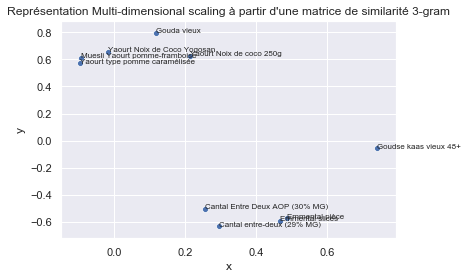

In [12]:
df_mds = pd.DataFrame({'x': two_dim_data[indices, 0],
                       'y': two_dim_data[indices, 1],
                       'product_name': sorted_values[indices]})
ax = sns.scatterplot(x='x', y='y', data=df_mds)
# afficher les noms de produits
for x, y, name_prod in df_mds.itertuples(index=False):
    ax.text(x=x, y=y, s=name_prod,
            fontsize=8)
# titre
ax.set_title(
    "Représentation Multi-dimensional scaling à partir d'une matrice de similarité 3-gram")

### Heatmap de la matrice de similarité

Nous pouvons afficher la matrice de similarité pour ces observations.

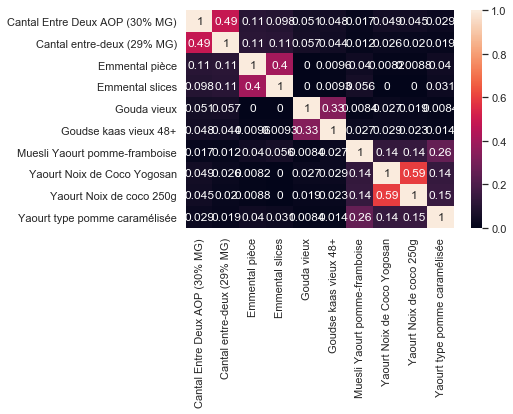

In [13]:
df_trans = pd.DataFrame(transformed_values[indices, :][:, indices],
                        index=sorted_values[indices],
                        columns=sorted_values[indices])
#
sns.heatmap(df_trans, annot=True)

## Geopandas

Le champ `first_packaging_code_geo` contient des coordonnées géographiques.

Il est donc possible de dessiner une carte avec `geopandas`:
https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

In [14]:
# TODO dessiner une carte à partir de first_packaging_code_geo
# df_off[["fp_lat","fp_lon"]] = df_off["first_packaging_code_geo"].str.split(",", 1, expand=True)
# df_off.fp_lat = round(df_off.fp_lat.astype(float), 2)
# df_off.fp_lon = round(df_off.fp_lon.astype(float), 2)
# df_off = df_off.drop(columns=["first_packaging_code_geo"])

## Exploration par facettes liées ?

https://seaborn.pydata.org/tutorial/relational.html#showing-multiple-relationships-with-facets